In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
# import seaborn as sns
# sns.set() # Setting seaborn as default style even if use only matplotlib
import GPy
import argparse
import sys 
import os
os.environ['PYTHONHASHSEED'] = '0'
plt.rcParams.update({'font.size': 9})

In [2]:
seed = 42

# Toy prob

In [3]:
np.random.seed(seed=seed)

In [4]:
g = lambda x: (-np.sin(10.0*np.pi*(x+1))/(2*x+1))-x**4
f = lambda x: (np.cos(g(x))**2)+np.sin(3*x)
std_dev_g = 0.2
std_dev_f = 0.1

In [5]:
''' Test data '''
X_p = np.linspace(0.0, 1.0, 150)[:,None]
z_p = g(X_p) + std_dev_g * np.random.RandomState(seed=seed).randn(*g(X_p).shape) # inexpensive measurements
y_p = f(X_p) + std_dev_f * np.random.RandomState(seed=seed).randn(*f(X_p).shape) # expensive measurements

(20, 1) (20, 1) (20, 1)


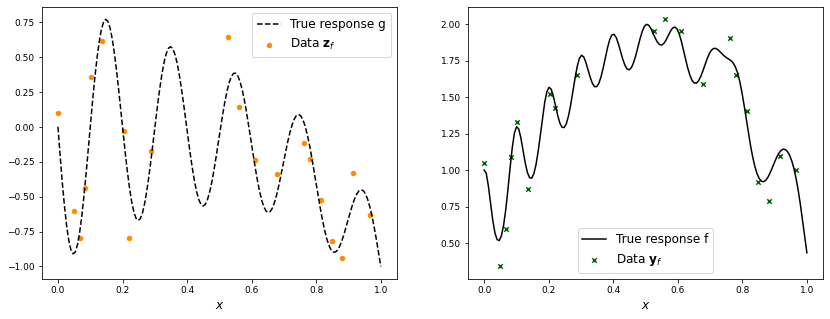

In [6]:
''' Train data '''
N_g = 60
N_f = 20

X_g = np.linspace(0, 1, N_g)[:,None]
z_g = g(X_g) + std_dev_g * np.random.RandomState(seed=seed).randn(*g(X_g).shape)

# for nested data
perm = np.random.RandomState(seed=seed).permutation(N_g)
X_f = X_g[perm[0:N_f]]
z_f = z_g[perm[0:N_f]]
y_f = f(X_f) + std_dev_f * np.random.RandomState(seed=seed).randn(*f(X_f).shape)

print (X_f.shape, z_f.shape, y_f.shape)

plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(X_p, g(X_p), 'k--', label="True response g")
plt.scatter(X_f, z_f, s=20, color='darkorange', marker='o', label=r"Data $\mathbf{z}_f$")
plt.xlabel('$x$', fontsize=12)
# plt.ylabel('$y$', fontsize=12)
plt.legend(loc="best", fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(X_p, f(X_p), 'k-', label="True response f")
plt.scatter(X_f, y_f, s=20, color='darkgreen', marker='x', label=r"Data $\mathbf{y}_f$")
plt.xlabel('$x$', fontsize=12)
# plt.ylabel('$y$', fontsize=12)
plt.legend(loc="best", fontsize=12)

plt.show()
plt.close()


GPR using {X=X_f, Y=y_f}

where y_f is noisy data


In [7]:
print ('Building GP between X_f and y_f')
k = GPy.kern.RBF(X_f.shape[1], ARD=True)
m = GPy.models.GPRegression(X_f, y_f, k)
m.Gaussian_noise.variance.constrain_fixed(std_dev_f**2)
m.optimize_restarts()
print(m)
print(m[".*Gaussian_noise"])

Building GP between X_f and y_f
Optimization restart 1/10, f = 42.37528753653864
Optimization restart 2/10, f = 19.330522792720153
Optimization restart 3/10, f = 19.330522792722
Optimization restart 4/10, f = 19.33052279272291
Optimization restart 5/10, f = 42.37528753653923
Optimization restart 6/10, f = 42.37528753654738
Optimization restart 7/10, f = 19.330522792724167
Optimization restart 8/10, f = 34.969837691578675
Optimization restart 9/10, f = 19.330522792722817
Optimization restart 10/10, f = 42.37528753657421

Name : GP regression
Objective : 19.330522792720153
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    1.4962616586139084  |      +ve      |        
  rbf.lengthscale          |  0.050034707459309394  |      +ve      |        
  Gaussian_noise.variance  |  0.010000000000000002  |   +ve fixed   |        
  index  |  GP_regre

In [8]:
print('GP Predictions') # posterior (f*|y)
postsam = m.posterior_samples_f(X_p, size=1000) # posterior_samples_f gives epistemic uncertainity only
print (postsam.shape)

mupred, varpred = np.mean(postsam, axis=2), np.var(postsam, axis=2)

GP Predictions
(150, 1, 1000)


GP Predictions plots
************************************************
y MRel.AE wrt truth: 0.16368395030770289
y MAE wrt truth: 0.24990695743708624
************************
y MRel.AE: 0.17821525399688448
y MAE: 0.268658919699678
************************************************


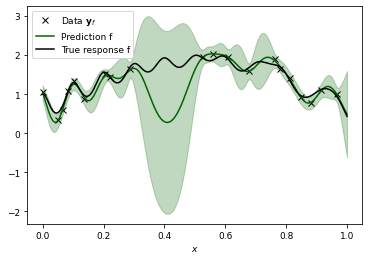

In [9]:
from sklearn.metrics import mean_absolute_error
def mean_relative_absolute_error(y_true, y_pred): 
    return np.mean( np.abs((y_pred-y_true)/y_true) )

print('GP Predictions plots')
y_MRelAE_wrt_truth = mean_relative_absolute_error( f(X_p), mupred )
y_MAE_wrt_truth = mean_absolute_error( f(X_p),  mupred )

y_MRelAE = mean_relative_absolute_error( y_p, mupred )
y_MAE = mean_absolute_error( y_p,  mupred )

print ('************************************************')
print ('y MRel.AE wrt truth: '+str(y_MRelAE_wrt_truth))
print ('y MAE wrt truth: '+str(y_MAE_wrt_truth ))

print ('************************')

print ('y MRel.AE: '+str(y_MRelAE))
print ('y MAE: '+str(y_MAE))
print ('************************************************')


fig, ax = plt.subplots()
Xdata = [X_f]
Ydata = [y_f]
Yp = [mupred]
Vp = [varpred]
markers = ['x']
colors = ['darkgreen']

for x, y, yp, vp, c, mk in zip(Xdata, Ydata, Yp, Vp, colors, markers):
    ax.plot(x, y, mk, color='black', markeredgewidth=1)
    ax.plot(X_p, yp, color=c)
    sp = np.sqrt(vp)
    lp = yp - 1.96 * sp
    up = yp + 1.96 * sp
    ax.fill_between(X_p.flatten(), lp.flatten(), up.flatten(), color=c,
                    alpha=0.25)
ax.plot(X_p, f(X_p), 'k-')
ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
plt.legend([r"Data $\mathbf{y}_f$", 'Prediction f', 'True response f'], loc='best')

# plt.savefig('pred.pdf',dpi=300)
plt.show()
plt.close()

In [10]:
print ('Required outputs:')
print ('Seed: '+str(seed)) 
print ('y MRel.AE wrt truth: '+str(y_MRelAE_wrt_truth))
print ('y MAE wrt truth: '+str(y_MAE_wrt_truth ))

Required outputs:
Seed: 42
y MRel.AE wrt truth: 0.16368395030770289
y MAE wrt truth: 0.24990695743708624
